In [ ]:
# ============================================================================
# K-NN Image Classification: Manhattan vs Euclidean
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
from collections import Counter
from google.colab import files
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Reproducibility
SEED = 42
np.random.seed(SEED)

In [ ]:
# ============================================================================
# STEP 1: UPLOAD AND EXTRACT DATASET
# ============================================================================

print("="*70)
print("DATASET UPLOAD")
print("="*70)
print("Please upload your dataset zip file (e.g. animal_dataset.zip)")

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]
print(f"✓ Uploaded: {zip_path}")

# Extract
extract_to = "dataset"
print(f"Extracting to '{extract_to}'...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("✓ Extraction complete")

DATASET UPLOAD
Please upload your dataset zip file (e.g. animal_dataset.zip)


Saving animal_dataset.zip to animal_dataset (2).zip
✓ Uploaded: animal_dataset (2).zip
Extracting to 'dataset'...
✓ Extraction complete


In [ ]:
# ============================================================================
# STEP 2: FIND DATASET FOLDER
# ============================================================================

def find_dataset_folder(base="dataset"):
    """Find folder containing class subfolders with images"""
    for root_dir, dirs, files in os.walk(base):
        subdirs = [d for d in os.listdir(root_dir)
                  if os.path.isdir(os.path.join(root_dir, d))
                  and not d.startswith('.')]

        if len(subdirs) >= 2:
            # Check if subdirs contain images
            for sd in subdirs:
                sd_path = os.path.join(root_dir, sd)
                imgs = [f for f in os.listdir(sd_path)
                       if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]
                if len(imgs) > 0:
                    return root_dir
    return base

dataset_path = find_dataset_folder(extract_to)
print(f"\n✓ Dataset path: {dataset_path}")
print(f"Contents: {os.listdir(dataset_path)}")


✓ Dataset path: dataset/animal_dataset
Contents: ['panda', 'dog', 'cat']



DATASET AND PREPROCESSING
Converting 32x32 grayscale images...
Found classes: ['cat', 'dog', 'panda']

Loading cat: 100 images
Loading dog: 100 images
Loading panda: 100 images

DATASET SUMMARY
Total images: 300
Classes: ['cat', 'dog', 'panda']
Per-class distribution: Counter({np.int32(0): 100, np.int32(1): 100, np.int32(2): 100})
Image vector length: 1024
Data range: [0.000, 1.000]



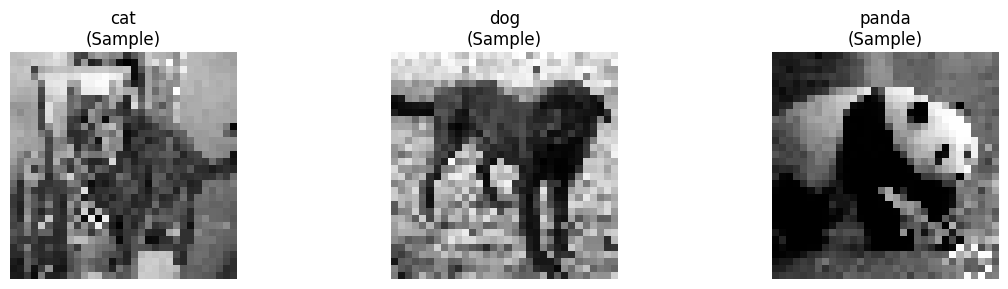

In [ ]:
# ============================================================================
# STEP 3: LOAD AND PREPROCESS IMAGES
# ============================================================================

def load_images_from_folder(folder, img_size=(32,32)):
    """
    Load images, convert to grayscale 32x32, normalize to [0,1]
    Returns: X (N,1024), y (N,), class_names list
    """
    images = []
    labels = []

    # Get class folders
    class_names = sorted([d for d in os.listdir(folder)
                         if os.path.isdir(os.path.join(folder, d))
                         and not d.startswith('.')])

    if len(class_names) == 0:
        raise ValueError(f"No class subfolders found in {folder}")

    print("\n" + "="*70)
    print("DATASET AND PREPROCESSING")
    print("="*70)
    print(f"Converting {img_size[0]}x{img_size[1]} grayscale images...")
    print(f"Found classes: {class_names}\n")

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        files = sorted([f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])

        print(f"Loading {class_name}: {len(files)} images")

        for fname in files:
            img_path = os.path.join(class_path, fname)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to 32x32
            resized = cv2.resize(gray, img_size)

            # Normalize to [0,1]
            normalized = resized.astype(np.float32) / 255.0

            # Flatten to vector
            images.append(normalized.flatten())
            labels.append(class_idx)

    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)

    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    print(f"Total images: {len(X)}")
    print(f"Classes: {class_names}")
    print(f"Per-class distribution: {Counter(y)}")
    print(f"Image vector length: {X.shape[1]}")
    print(f"Data range: [{X.min():.3f}, {X.max():.3f}]")
    print("="*70 + "\n")

    return X, y, class_names

# Load dataset
X, y, class_names = load_images_from_folder(dataset_path, img_size=(32,32))

# Show sample images
try:
    plt.figure(figsize=(12,3))
    classes = sorted(list(set(y)))
    for i, cls in enumerate(classes):
        idx = np.where(y==cls)[0][0]
        plt.subplot(1, len(classes), i+1)
        plt.imshow(X[idx].reshape(32,32), cmap='gray')
        plt.title(f"{class_names[cls]}\n(Sample)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not show preview: {e}")

In [ ]:
# ============================================================================
# STEP 4: 5-FOLD CROSS-VALIDATION
# ============================================================================

def cross_validate_knn(X, y, k_values, metric='euclidean', n_folds=5):
    """Perform 5-fold cross-validation"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    results = {k: [] for k in k_values}

    print(f"Running {n_folds}-fold cross-validation with {metric.upper()} distance...")

    fold = 1
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        print(f"  Fold {fold}/{n_folds}: train={len(X_train)}, val={len(X_val)}")

        for k in k_values:
            clf = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_val)
            results[k].append(accuracy_score(y_val, preds))

        fold += 1

    # Compute average accuracy across all folds
    avg = {k: np.mean(results[k]) for k in k_values}

    print("\nResults:")
    for k in k_values:
        print(f"  K={k:2d}: {avg[k]*100:6.2f}%")

    return avg, results

# Test K values
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

print("\n" + "="*70)
print("MODEL BUILDING AND EVALUATION")
print("="*70)
print("Using k-Nearest Neighbors (k-NN) algorithm")
print("Distance metrics: Manhattan (L1) and Euclidean (L2)")
print("="*70 + "\n")

# Manhattan (L1) Distance
print("="*70)
print("MANHATTAN (L1) DISTANCE")
print("="*70)
manhattan_avg, manhattan_all = cross_validate_knn(X, y, k_values, metric='manhattan', n_folds=5)

# Euclidean (L2) Distance
print("\n" + "="*70)
print("EUCLIDEAN (L2) DISTANCE")
print("="*70)
euclidean_avg, euclidean_all = cross_validate_knn(X, y, k_values, metric='euclidean', n_folds=5)




MODEL BUILDING AND EVALUATION
Using k-Nearest Neighbors (k-NN) algorithm
Distance metrics: Manhattan (L1) and Euclidean (L2)

MANHATTAN (L1) DISTANCE
Running 5-fold cross-validation with MANHATTAN distance...
  Fold 1/5: train=240, val=60
  Fold 2/5: train=240, val=60
  Fold 3/5: train=240, val=60
  Fold 4/5: train=240, val=60
  Fold 5/5: train=240, val=60

Results:
  K= 1:  37.00%
  K= 3:  37.67%
  K= 5:  35.67%
  K= 7:  37.67%
  K= 9:  42.00%
  K=11:  39.67%
  K=13:  40.33%
  K=15:  40.67%

EUCLIDEAN (L2) DISTANCE
Running 5-fold cross-validation with EUCLIDEAN distance...
  Fold 1/5: train=240, val=60
  Fold 2/5: train=240, val=60
  Fold 3/5: train=240, val=60
  Fold 4/5: train=240, val=60
  Fold 5/5: train=240, val=60

Results:
  K= 1:  35.00%
  K= 3:  35.67%
  K= 5:  33.33%
  K= 7:  36.00%
  K= 9:  38.33%
  K=11:  35.33%
  K=13:  36.67%
  K=15:  36.67%



RESULTS AND ANALYSIS


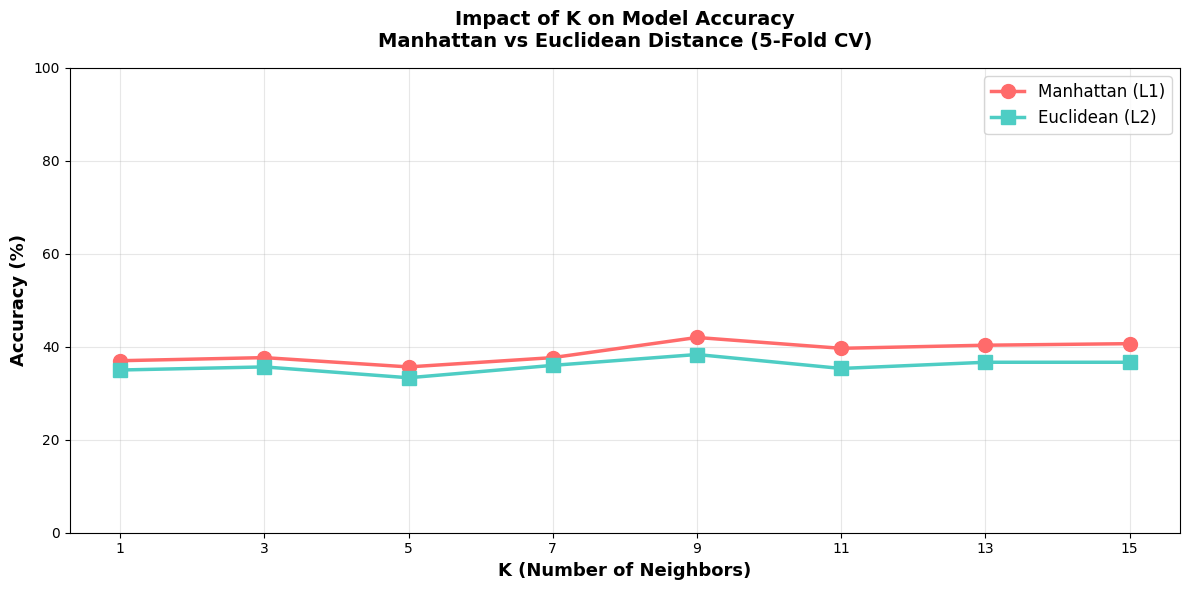


BEST CONFIGURATIONS
Manhattan (L1): K=9, Accuracy=42.00%
Euclidean (L2): K=9, Accuracy=38.33%

✓ Winner: MANHATTAN (L1) with K=9 (42.00%)


In [ ]:
# ============================================================================
# STEP 5: PLOT COMPARISON GRAPH
# ============================================================================

print("\n" + "="*70)
print("RESULTS AND ANALYSIS")
print("="*70)

plt.figure(figsize=(12,6))
plt.plot(k_values, [manhattan_avg[k]*100 for k in k_values],
         '-o', linewidth=2.5, markersize=10, label='Manhattan (L1)', color='#FF6B6B')
plt.plot(k_values, [euclidean_avg[k]*100 for k in k_values],
         '-s', linewidth=2.5, markersize=10, label='Euclidean (L2)', color='#4ECDC4')
plt.xlabel('K (Number of Neighbors)', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Impact of K on Model Accuracy\nManhattan vs Euclidean Distance (5-Fold CV)',
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(k_values)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 100])
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: DETERMINE BEST CONFIGURATION
# ============================================================================

best_m_k = max(manhattan_avg, key=manhattan_avg.get)
best_e_k = max(euclidean_avg, key=euclidean_avg.get)
best_m_acc = manhattan_avg[best_m_k]
best_e_acc = euclidean_avg[best_e_k]

print("\n" + "="*70)
print("BEST CONFIGURATIONS")
print("="*70)
print(f"Manhattan (L1): K={best_m_k}, Accuracy={best_m_acc*100:.2f}%")
print(f"Euclidean (L2): K={best_e_k}, Accuracy={best_e_acc*100:.2f}%")

if best_e_acc > best_m_acc:
    best_metric = 'euclidean'
    best_k = best_e_k
    best_acc = best_e_acc
    print(f"\n✓ Winner: EUCLIDEAN (L2) with K={best_k} ({best_acc*100:.2f}%)")
else:
    best_metric = 'manhattan'
    best_k = best_m_k
    best_acc = best_m_acc
    print(f"\n✓ Winner: MANHATTAN (L1) with K={best_k} ({best_acc*100:.2f}%)")

print("="*70)



FINAL MODEL EVALUATION

Training set: 240 images
Test set: 60 images

Training final model with MANHATTAN distance and K=9...
Final Test Accuracy: 40.00%

TOP 5 PREDICTIONS


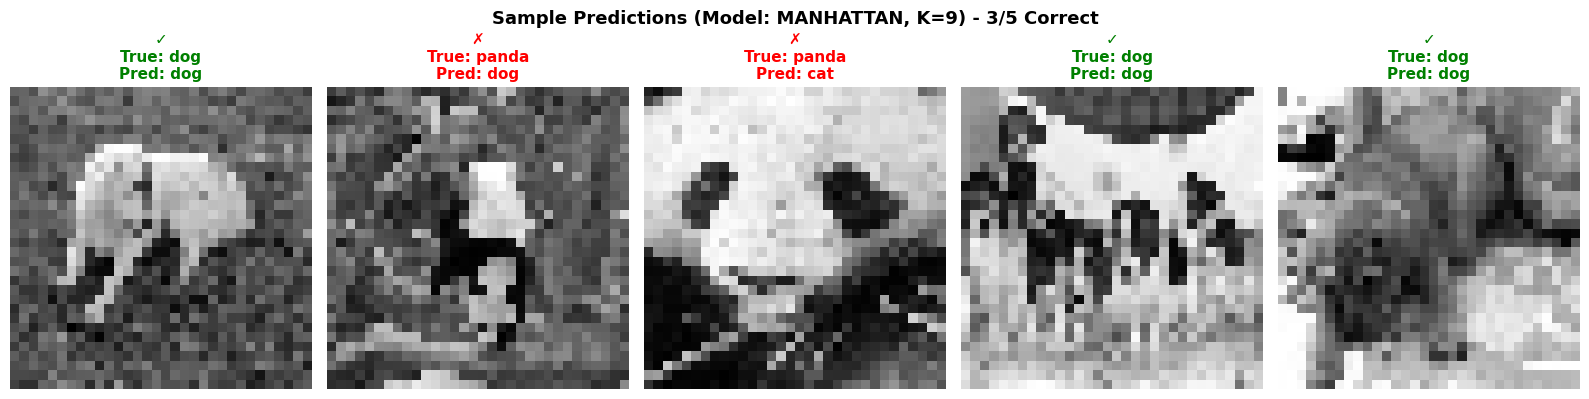

In [ ]:

# ============================================================================
# STEP 7: FINAL MODEL AND TEST
# ============================================================================

print("\n" + "="*70)
print("FINAL MODEL EVALUATION")
print("="*70)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nTraining set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")
print(f"\nTraining final model with {best_metric.upper()} distance and K={best_k}...")

# Train final model
final_clf = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, n_jobs=-1)
final_clf.fit(X_train, y_train)

# Make predictions
y_pred = final_clf.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)

print(f"Final Test Accuracy: {final_acc*100:.2f}%")

# ============================================================================
# STEP 8: TOP 5 PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("TOP 5 PREDICTIONS")
print("="*70)

n_show = min(5, len(X_test))
idxs = np.random.choice(len(X_test), n_show, replace=False)

plt.figure(figsize=(16,4))
correct_count = 0

for i, idx in enumerate(idxs):
    plt.subplot(1, n_show, i+1)
    plt.imshow(X_test[idx].reshape(32,32), cmap='gray')

    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]

    is_correct = (true_label == pred_label)
    if is_correct:
        correct_count += 1

    color = 'green' if is_correct else 'red'
    status = '✓' if is_correct else '✗'

    plt.title(f"{status}\nTrue: {true_label}\nPred: {pred_label}",
              color=color, fontsize=11, fontweight='bold')
    plt.axis('off')

plt.suptitle(f'Sample Predictions (Model: {best_metric.upper()}, K={best_k}) - {correct_count}/{n_show} Correct',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
